# 1 Introduzione

Questa è una guida, ad uso personale, che ho scritto per allenarmi nell'utilizzo di alcune
funzionalità di Python.  Il dataset che verrà utilizzato riguarda i punteggi
 dei giocatori di scacchi registrati al FIDE dal 2000 al 2021, disponibili su https://ratings.fide.com/download.phtml.

Ho scelto questo dataset un po' per curiosità e un po' perché permette di applicare delle statistiche interessanti.
Si tratta infatti di un dataset abbastanza grande da costringerci ad ottimizzare le operazioni, ma
 non troppo da non farci perdere troppo tempo.

Il file *load_data.py* contiene le istruzioni necessarie per scaricare il dataset direttamente dal sito della FIDE.
Già qui abbiamo un problema, perché si tratta di una serie di file .txt formattati in modo diverso
a seconda della data di redazione.

Comunque alla fine otteniamo due dataset, uno contenente le statistiche mese per mese (inizialmente
solo alcuni mesi sono considerati, più recentemente abbiamo statistiche per ogni mese) e uno contenente
la lista di tutti i giocatori iscritti al FIDE. I giocatori sono identificati dal numero ID, presente
in entrambi i dataset.
Vi è inoltre un terzo dataset contenente il ranking completo per marzo 2021, tutti gli elo inclusi, e con nazionalità
e date di nascita provenienti dal dataset originali, in modo da limitare i missing data

Qui inizia questo notebook, che ripeto, ha sopratutto lo scopo di servire da cheatsheet.
Se invece siete interessati unicamente alle statistiche sugli scacchi, presentate in modo più organico,
consultate il file *statistics.ipynb*

Iniziamo col ** caricare il dataset **

In [50]:
# thanks to  https://realpython.com/pandas-groupby/
import pandas as pd
import load_data
import seaborn as sns
import matplotlib.pyplot as plt
#!pip install plotly
import plotly.express as px #per le mappe
rank = load_data.load_ranking()
players = load_data.load_players()
mar21 = load_data.load_mar21()
print(rank.head())
print(players.head())
print(mar21.head())

        id                  name     elo title       date
0  1701991         Aaberg, Anton  2300.0   NaN 2001-01-01
1  1401815        Aagaard, Jacob  2374.0    im 2001-01-01
2  1500503  Aarland, Stein Arild  2275.0   NaN 2001-01-01
3  5000092         Aaron, Manuel  2315.0    im 2001-01-01
4  5004373    Aarthie, Ramaswamy  2250.0   wim 2001-01-01
         id                       name country  birth_year sex
0  33200025                        NaN     SKN           0   M
1  10688862       A Abdel Maabod, Hoda     EGY        2009   F
2  10224084  A B M Hasibuzzaman, Tapan     BAN        1977   M
3  10245154      A B M Jobair, Hossain     BAN        1998   M
4  10243054  A B M Mustakim, Chowdhury     BAN        2013   M
         id                      name country sex title     elo  birth_year  \
0  25121731                A C J John     IND   M   NaN  1063.0        1987   
1  35077023            A Chakravarthy     IND   M   NaN  1151.0        1986   
2  10207538          A E M, Doshtagir

Vediamo quali sono le nazioni che hanno più iscritti

Text(0.5, 1.0, 'FIDE chess players by country')

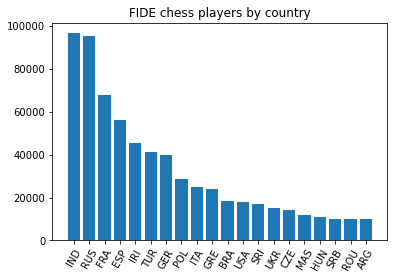

In [51]:
country_numb = players["country"].value_counts()
top_20 = country_numb.head(20)
plt.bar(top_20.index, top_20)
plt.xticks(rotation=60)
plt.title("FIDE chess players by country")#vertical x labels for better reading

Proviamo una distinzione per sesso:

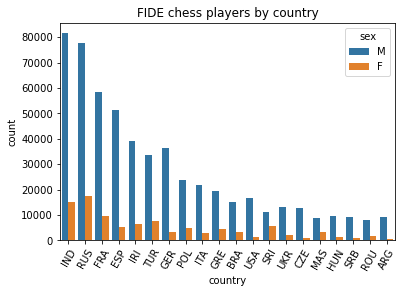

In [52]:
#usando order decidiamo quali classi plottare e in che ordine
sns.countplot(x="country", hue="sex", data=players, order=top_20.index)
plt.title("FIDE chess players by country")
plt.xticks(rotation=60); #<-- il carattere ; sopprime l'output testo in jupyter (ultima istruzione)

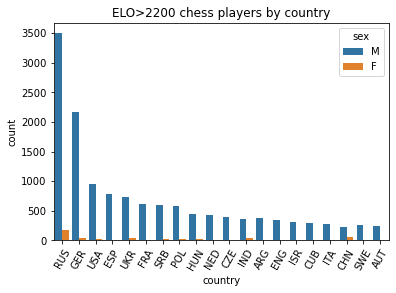

In [53]:
best_players = mar21[mar21.elo>2200]
country_numb = best_players["country"].value_counts()
top_20 = country_numb.head(20)
sns.countplot(x="country", hue="sex", data= best_players, order=top_20.index)
plt.title("ELO>2200 chess players by country")
plt.xticks(rotation=60); #<-- il carattere ; sopprime l'output testo in jupyter (ultima istruzione)

Come sono distribuiti gli ELO?

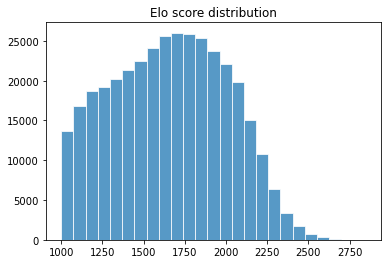

In [54]:
plt.hist(x=mar21["elo"], bins=25, ec='white', alpha=0.75);
plt.title("Elo score distribution");

Proviamo a vedere qual è la distribuzione delle età:

<ipython-input-55-fd7bce28fe72>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



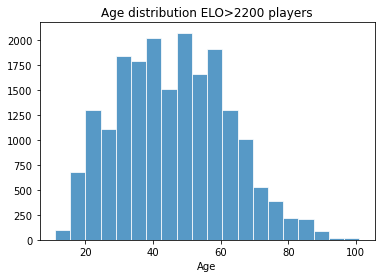

In [55]:
# Togliamo i dati in cui manca la data di nascita
mar21_age = mar21[mar21["birth_year"]!=0]
mar21_age["age"] = mar21_age["date"].dt.year - mar21_age["birth_year"]
plt.hist(x=mar21_age[mar21_age["elo"]>2200]["age"], bins=20, ec='white', alpha=0.75);
plt.title("Age distribution ELO>2200 players")
plt.xlabel("Age");

Proviamo ora a studiare i dati annuali (cambiamo quindi dataset). Dato che abbiamo dei dati mensili, proviamo a raggrupparli per anno.
Prendiamo la media dei punteggi ELO per ogni anno.

In [56]:
del(rank["name"]) #we already have the name column in player dataset
joined = pd.merge(players, rank, how='inner', on='id')
print(joined.sample(5)) #invece di stampare i primi 5, ne stampo 5 a caso
by_year = joined.groupby(by=[joined["date"].dt.year, joined["id"]])
year_data = by_year.agg(name=('name', 'first'), elo=('elo', 'mean'), country=('country', 'first'), sex=('sex', 'first'), title=('title', 'first'), birth_year=('birth_year', 'first'))
print(year_data.sample(5))
# trasformiamo gli indici in colonne
year_data = year_data.reset_index(level=['id', 'date'])
year_data.rename(columns={'date': 'year'}, inplace=True)
year_data["age"] = year_data["year"] - year_data["birth_year"]
year_data = year_data[year_data["birth_year"]!=0]
year_data.head()

               id                       name country  birth_year sex     elo  \
490637    3508498  Diaz Hernandez, Heriberto     CUB        1991   M  2345.0   
2534432   1501364      Wisloff-Nilssen, Sven     NOR        1969   M  2225.0   
2151683   2400154              Sinclair, Ian     SCO           0   M  2295.0   
2449326    223654          Verstraeten, Rein     BEL        1995   M  2316.0   
126750   12537608               Babaee, Reza     IRI           0   M  2333.0   

        title       date  
490637     fm 2017-11-01  
2534432   NaN 2017-07-01  
2151683   NaN 2003-07-01  
2449326    fm 2015-12-01  
126750    NaN 2010-07-01  
                            name     elo country sex title  birth_year
date id                                                               
2017 13301527  Gharamian, Tigran  2622.1     FRA   M    gm        1984
2007 4100859   Chekhov, Valery A  2457.0     RUS   M    gm        1955
2017 4163362   Katkov, Alexander  2207.0     RUS   M   NaN        1946
20

,year,id,name,elo,country,sex,title,birth_year,age
0,2001,100013,"Campora, Daniel H.",2518.333333,ARG,M,gm,1957,44
1,2001,100021,"Quinteros, Miguel A.",2503.000000,ARG,M,gm,1947,54
2,2001,100030,"Montenegro, Noe",2485.000000,ARG,M,gm,1996,5
3,2001,100048,"Iapichello, Javier",2454.000000,ARG,M,gm,1990,11
4,2001,100072,"Adla, Diego",2501.666667,ARG,M,im,1968,33


Per esempio possiamo stampare i top 5 giocatori per anno

In [57]:
for year, frame in year_data.groupby(by="year"):
    print(f"Top 5 female players in {year}")
    print(frame[frame.sex=="F"].sort_values(by="elo", ascending=False).head(5))
    print(f"Top 5 male players in {year}")
    print(frame[frame.sex=="M"].sort_values(by="elo", ascending=False).head(5))
    print(40*"_")


Top 5 female players in 2001
       year        id               name          elo country sex title  \
1872   2001    700070      Polgar, Judit  2682.666667     HUN   F   wgm   
17250  2001  14200074  Ibragimova, Iroda  2649.000000     UZB   F    gm   
1873   2001    700088      Polgar, Susan  2565.000000     HUN   F   wgm   
15375  2001   8600147           Xie, Jun  2554.333333     CHN   F   wgm   
10084  2001   4129725  Galliamova, Alisa  2549.333333     RUS   F   wgm   

       birth_year  age  
1872         1976   25  
17250        1991   10  
1873         1969   32  
15375        1970   31  
10084        1972   29  
Top 5 male players in 2001
       year       id                   name          elo country sex title  \
8919   2001  4100018        Kasparov, Garry  2841.666667     RUS   M    gm   
8967   2001  4101588      Kramnik, Vladimir  2794.333333     RUS   M    gm   
14475  2001  5000017     Anand, Viswanathan  2784.666667     IND   M    gm   
9460   2001  4116992  Morozevic

Vediamo qualche statistica sui giocatori top N


        year       id                        name     elo country sex title  \
420045  2021  1002864              Wiersma, Eelke  2301.0     NED   M    im   
320122  2016  4171519          Tkachenko, Evgeniy  2242.0     RUS   M    fm   
323698  2016  5117054   Ayala Pena, Eduardo Azael  2201.0     MEX   M    cm   
183647  2010  1104314               Murat, Tomasz  2210.0     POL   M   NaN   
224888  2012   909025          Prohorov, Vladimir  2230.0     SRB   M   NaN   
104167  2006  2901609            Shikerov, Stefan  2322.0     BUL   M   NaN   
427626  2021  4152158         Kazachansky, Sergei  2261.0     RUS   M   NaN   
382628  2019  3400255  Belmonte Schwarzbaum, Juan  2272.0     CHI   M   NaN   
25203   2002  2219220           Rojas Sola, Pedro  2209.0     ESP   M   NaN   
131769  2007  4675568         Korentsvit, Valeriy  2292.0     GER   M   NaN   

        birth_year  age  
420045        1973   48  
320122        1988   28  
323698        1994   22  
183647        1936   74  


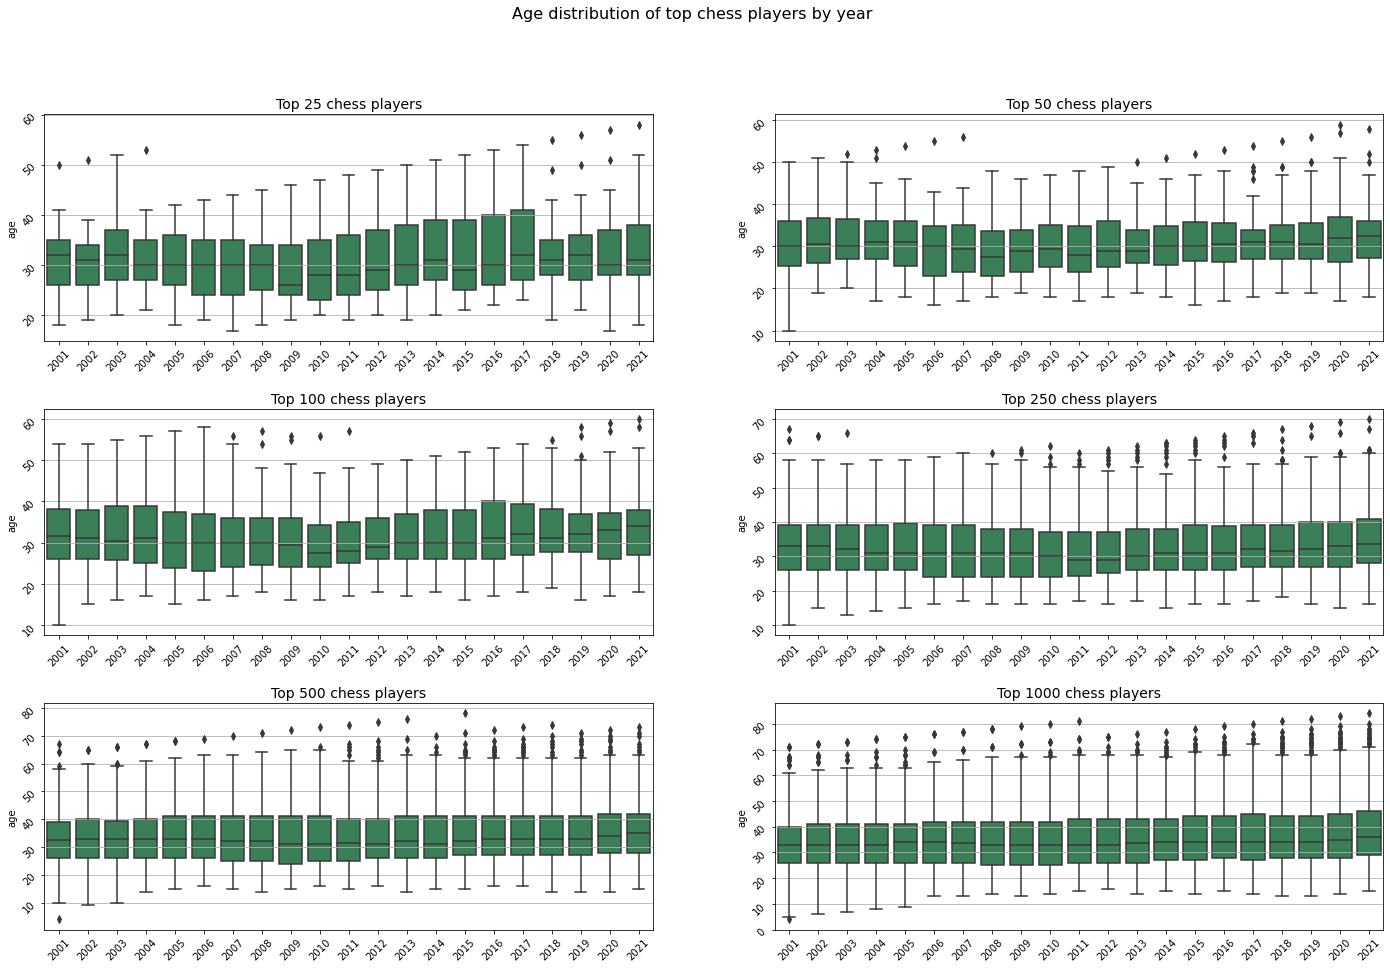

In [58]:
# Con groupby, ogni istruzione viene applicata ad un frame alla volta.
# Quindi per esempio head(1) restituisce il primo elemento di ogni gruppo
# Quindi se vogliamo i top n rispetto ad una colonna, bisogna prima ordinare
# secondo quella colonna, e poi applicare head(n)
year_data = year_data.sort_values(by="elo", ascending=False)
print(year_data.sample(10))
by_year = year_data.groupby("year")

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(24,15))
fig.suptitle("Age distribution of top chess players by year", fontsize=16)
for i, n in enumerate([25, 50, 100, 250, 500, 1000]):
    top = by_year.head(n)
    print(top)
    sns.boxplot(x=top.year, y=top.age, ax=ax[i//2][i%2], color='seagreen')
    ax[i//2][i%2].tick_params(labelrotation=45)
    ax[i//2][i%2].set_title(f"Top {n} chess players", fontsize=14)
    fig.tight_layout;
    ax[i//2][i%2].set_xlabel("")
    ax[i//2][i%2].yaxis.grid(True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

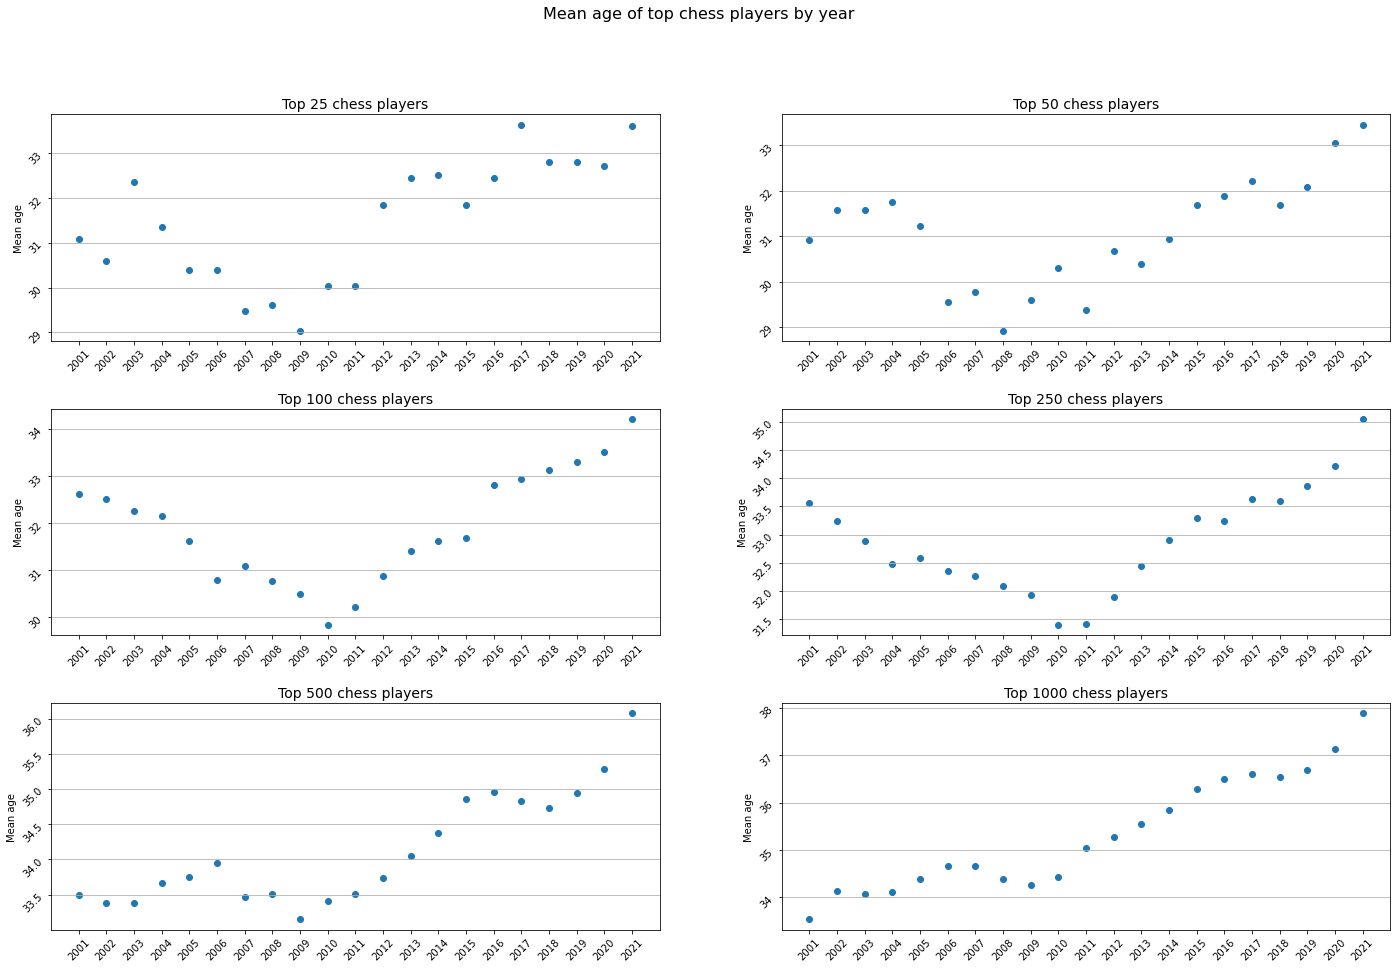

In [59]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(24,15))
fig.suptitle("Mean age of top chess players by year", fontsize=16)
for i, n in enumerate([25, 50, 100, 250, 500, 1000]):
    top = by_year.head(n)
    top_age_mean = top.groupby(by="year")["age"].mean()
    ax[i//2][i%2].scatter(top_age_mean.index, top_age_mean)

    #Scelgo esplicitamente che etichette voglio sull'asse x
    ax[i//2][i%2].xaxis.set_ticks(range(2001,2022))
    #Le ruoto di 45°
    ax[i//2][i%2].tick_params(labelrotation=45)
    ax[i//2][i%2].set_title(f"Top {n} chess players", fontsize=14)
    ax[i//2][i%2].set_ylabel("Mean age")
    #Aggiungo la griglia
    ax[i//2][i%2].yaxis.grid(True)
    #Specifico gli spazi tra i subplot
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

Potevamo fare le cose diversamente, per esempio aggiungendo un colonna
per il posto occupato nella classifica:

In [60]:
#Aggiungiamo una colonna per il posto occupato nella classifica in quell'anno
year_data["rank"] = year_data.groupby(["year"])["elo"].rank("dense", ascending=False)
year_data["rank_sex"] = year_data.groupby(["year", "sex"])["elo"].rank("dense", ascending=False)
#Proviamo a cercare le Polgar
year_data[year_data["name"].str.contains("Polgar")]

,year,id,name,elo,country,sex,title,birth_year,age,rank,rank_sex
77213,2005,700070,"Polgar, Judit",2732.666667,HUN,F,gm,1976,29,8.0,1.0
57596,2004,700070,"Polgar, Judit",2728.000000,HUN,F,NaN,1976,28,10.0,1.0
118007,2007,700070,"Polgar, Judit",2714.000000,HUN,F,gm,1976,31,16.0,1.0
38406,2003,700070,"Polgar, Judit",2713.333333,HUN,F,NaN,1976,27,12.0,1.0
97432,2006,700070,"Polgar, Judit",2710.333333,HUN,F,gm,1976,30,17.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
223731,2012,700215,"Polgar, Istvan",2425.000000,HUN,M,fm,1944,68,1092.0,1075.0
97444,2006,700215,"Polgar, Istvan",2425.000000,HUN,M,fm,1944,62,568.0,564.0
380525,2019,2064880,"Polgar-Shutzman, Tom",2232.444444,USA,M,NaN,1999,20,3256.0,3200.0
402177,2020,2064880,"Polgar-Shutzman, Tom",2215.000000,USA,M,NaN,1999,21,3180.0,3113.0


Quante sono le donne rispetto agli uomini?

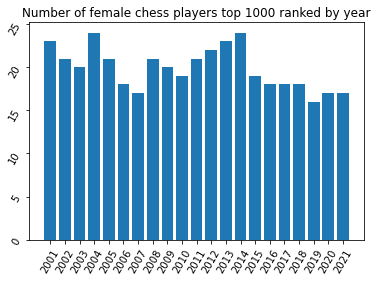

In [84]:
n = 1000
top = by_year.head(n)
topF = top[top.sex=='F']
sex_comp = topF.groupby(["year"]).elo.count()
sex_comp = sex_comp.reset_index(level=['year'])
plt.bar(sex_comp.year, sex_comp.elo)
ax = plt.gca() #per ottenere l'oggetto axis associato al plot
ax.xaxis.set_ticks(range(2001,2022))
ax.tick_params(labelrotation=60)
ax.set_title("Number of female chess players top 1000 ranked by year");

Ritorniamo al dataset di marzo.
Facciamo un grafico che mostra quante donne in percentuale hanno un certo ELO rispetto agli uomini
Quante sono le donne rispetto agli uomini?

Proviamo a fare un po' di statistiche per nazione

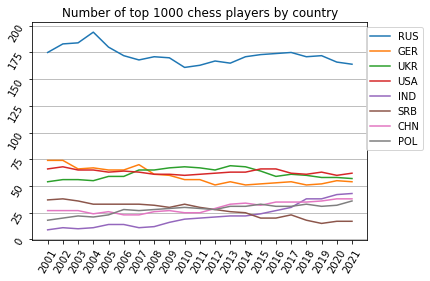

In [85]:
n = 1000
top = by_year.head(n)
country_count = top.groupby(["year", "country"]).elo.count()
country_count = country_count.reset_index(level=['year', 'country'])
country_count = country_count.sort_values("elo", ascending=False)
top_country = country_count.country.unique()[0:8]
sns.lineplot(data=country_count[country_count.country.isin(top_country)], x="year", y="elo", hue = "country")
ax = plt.gca()
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(bbox_to_anchor=(0.98, 1), loc='upper left')
ax.xaxis.set_ticks(range(2001,2022))
ax.yaxis.grid(True)
ax.set_title("Number of top 1000 chess players by country");
ax.tick_params(labelrotation=60);

Ritornando al dataset di marzo, quali sono le nazioni con più giocatori top 1000?

In [103]:

gapminder = px.data.gapminder().query("year==2007")

In [166]:
n = 1000
mar21 = mar21.sort_values(by="elo", ascending=False)
top = mar21.head(n)
country21 = top.groupby(["country"]).elo.count()
country21 = country21.reset_index(level=['country'])
#gapminder = px.data.gapminder().query("year==2007")
print(country21)
fig = px.choropleth(country21, locations="country",
                    color="elo",
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

   country  elo
0      ALB    1
1      ALG    1
2      ARG   14
3      ARM   21
4      AUS    7
..     ...  ...
70     UAE    1
71     UKR   58
72     USA   62
73     UZB   10
74     VIE    5

[75 rows x 2 columns]


Purtoppo i country code sono codificati in modo diverso. Usano lo standard iso_alpha invece di IOC
per esempio Germania è codificata con GER invece di DEU.
Devo quindi convertire i codici.
Ho trovato una tabella su wikipedia, che ho ricopiato su Calc per salvarla in csv.
Cerchiamo ora di trasformarla in dizionario

In [182]:
country_codes = pd.read_csv("processed_dataset/country_codes.csv")
# Togliamo gli spazi bianchi
country_codes["IOC"] = country_codes["IOC"].str.strip()
country_codes["ISO"] = country_codes["ISO"].str.strip()
country_codes = country_codes.dropna()
print(country_codes)
country_codes = country_codes.set_index("IOC")
country_codes = country_codes["ISO"]
country_dict = country_codes.to_dict()
print(country_dict)

                Country  IOC  FIFA  ISO
0          Afghanistan   AFG  AFG   AFG
2              Albania   ALB  ALB   ALB
3              Algeria   ALG  ALG   DZA
4    American Samoa[2]   ASA  ASA   ASM
5              Andorra   AND  AND   AND
..                  ...  ...   ...  ...
246          Venezuela   VEN  VEN   VEN
247            Vietnam   VIE  VIE   VNM
251              Yemen   YEM  YEM   YEM
252             Zambia   ZAM  ZAM   ZMB
253           Zimbabwe   ZIM  ZIM   ZWE

[198 rows x 4 columns]
{'AFG': 'AFG', 'ALB': 'ALB', 'ALG': 'DZA', 'ASA': 'ASM', 'AND': 'AND', 'ANG': 'AGO', 'ANT': 'ATG', 'ARG': 'ARG', 'ARM': 'ARM', 'ARU': 'ABW', 'AUS': 'AUS', 'AUT': 'AUT', 'AZE': 'AZE', 'BAH': 'BHS', 'BRN': 'BHR', 'BAN': 'BGD', 'BAR': 'BRB', 'BLR': 'BLR', 'BEL': 'BEL', 'BIZ': 'BLZ', 'BEN': 'BEN', 'BER': 'BMU', 'BHU': 'BTN', 'BOL': 'BOL', 'BIH': 'BIH', 'BOT': 'BWA', 'BRA': 'BRA', 'IVB': 'VGB', 'BRU': 'BRN', 'BUL': 'BGR', 'BUR': 'BFA', 'BDI': 'BDI', 'CAM': 'KHM', 'CMR': 'CMR', 'CAN': 'CAN', 'CPV'

Usiamo il dizionario per rimappare i valori delle nazioni e riproviamo a plottare

In [168]:
# Usiamo map che è più veloce di replace quando ci sono molti indici
country21["country"] = country21["country"].map(country_dict)

fig = px.choropleth(country21, locations="country",
                    color="elo",
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

Molto bello, ma bisogna vedere questi dati rapportati alla popolazione,
altrimenti la mappa coi gradienti non ci sarà molto utile
Uso questo dataset https://datahub.io/JohnSnowLabs/population-figures-by-country

In [169]:
population = pd.read_csv("processed_dataset/population.csv")
#Conservo solo l'ultimo anno
population = population.iloc[:,[1,-1]]
#rinomino le colonne
population.rename(columns={'Country_Code': 'country', 'Year_2016': 'population'}, inplace=True)
population

,country,population
0,ABW,104822.0
1,AFG,34656032.0
2,AGO,28813463.0
3,ALB,2876101.0
4,AND,77281.0
...,...,...
258,XKX,1816200.0
259,YEM,27584213.0
260,ZAF,55908865.0
261,ZMB,16591390.0


Faccio un merge, e discretizzo in intervalli

In [349]:
import numpy as np
n = 1000
mar21 = mar21.sort_values(by="elo", ascending=False)
top = mar21.head(n)
country21 = top.groupby(["country"]).elo.count()
country21 = country21.reset_index(level=['country'])
country21["country"] = country21["country"].map(country_dict)
chess_pop = pd.merge(country21, population, how='inner', on='country')
chess_pop["top_pl_freq"] = chess_pop["elo"] / chess_pop["population"]*1e6
#Discretizzo i valori per aumentare la leggibilità
chess_pop["cl_top_pl_freq"] =pd.cut(chess_pop["top_pl_freq"],bins = [0, 0.05, 0.1, 0.25, 0.5, 1, 1.5, 2, 20], labels=["<0.05","0.05-0.1", "0.1-0.25", "0.25-0.5", "0.5-1", "1-1.5", "1.5-2", ">2"])
#Ordino i valori in modo che le etichette appaiano nell'ordine corretto
chess_pop = chess_pop.sort_values("top_pl_freq", ascending=True)
print(chess_pop)

   country  elo    population  top_pl_freq cl_top_pl_freq
29     IDN    3  2.611155e+08     0.011489          <0.05
42     MEX    2  1.275404e+08     0.015681          <0.05
46     MMR    1  5.288522e+07     0.018909          <0.05
1      DZA    1  4.060605e+07     0.024627          <0.05
14     CHN   38  1.378665e+09     0.027563          <0.05
..     ...  ...           ...          ...            ...
37     LVA    7  1.960424e+06     3.570656             >2
16     HRV   16  4.170600e+06     3.836378             >2
25     GEO   18  3.719300e+06     4.839620             >2
3      ARM   21  2.924816e+06     7.179939             >2
32     ISL    6  3.342520e+05    17.950528             >2

[71 rows x 5 columns]


In [350]:
fig = px.choropleth(chess_pop, locations="country",#dataset e colonna coi codici nazione
                    color="cl_top_pl_freq",#colonna del dataset che viene mappata
                    hover_name="country", # column to add to hover information
                    #sequenza discreta per migliorare la leggibilità (maledetta Islanda!)
                    color_discrete_sequence= px.colors.sequential.Plasma_r,
                    title="Top 1000 chess players per million people",
                    #Tolgo l'etichette della legenda
                    labels={
                     "cl_top_pl_freq": " ",
                    })

fig.show()

In [291]:
chess_pop[chess_pop["top_pl_freq"]>0]

0     2
1     0
2     2
3     7
4     2
     ..
66    1
67    4
68    1
69    2
70    0
Name: cl_top_pl_freq, Length: 71, dtype: int32